Imports

In [53]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
)




Data Loading & Exploration

In [54]:
df = pd.read_csv("synthetic_retail_transactions.csv", parse_dates=["InvoiceDate"])
print("Rows:", len(df))
df.head()

Rows: 2467


,InvoiceNo,CustomerID,InvoiceDate,ProductID,ProductName,Category,UnitPrice,Quantity,Amount
0,INV200455,C1197,2024-01-01 01:47:44,P054,Cranberry Sauce,Seasonal,3.22,1,3.22
1,INV200455,C1197,2024-01-01 01:47:44,P005,Coffee,Beverages,8.58,2,17.16
2,INV200174,C1182,2024-01-01 05:27:55,P051,Hot Dogs,Seasonal,2.47,1,2.47
3,INV200917,C1089,2024-01-01 10:00:51,P012,Parmesan,Dairy,3.76,2,7.52
4,INV200917,C1089,2024-01-01 10:00:51,P010,Pasta,Pantry,1.66,2,3.32


In [55]:
# Display basic information
print("\nDataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    2467 non-null   object        
 1   CustomerID   2467 non-null   object        
 2   InvoiceDate  2467 non-null   datetime64[ns]
 3   ProductID    2467 non-null   object        
 4   ProductName  2467 non-null   object        
 5   Category     2467 non-null   object        
 6   UnitPrice    2467 non-null   float64       
 7   Quantity     2467 non-null   int64         
 8   Amount       2467 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 173.6+ KB
None


In [56]:
# Understand the columns
print("Column Descriptions:")
print("- InvoiceNo: Invoice number (unique per transaction)")
print("- CustomerID: Unique customer identifier")
print("- InvoiceDate: Date and time of transaction")
print("- ProductID: Product code")
print("- ProductName: Product name")
print("- Category: Product category")
print("- UnitPrice: Price per unit")
print("- Quantity: Number of items purchased")
print("- Amount: Total price (Quantity × UnitPrice)")

# Basic statistics
print("\nBasic Statistics:")
print(f"Total transaction rows: {len(df)}")
print(f"Unique transactions (InvoiceNo): {df['InvoiceNo'].nunique()}")
print(f"Unique customers: {df['CustomerID'].nunique()}")
print(f"Unique products: {df['ProductID'].nunique()}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")


Column Descriptions:
- InvoiceNo: Invoice number (unique per transaction)
- CustomerID: Unique customer identifier
- InvoiceDate: Date and time of transaction
- ProductID: Product code
- ProductName: Product name
- Category: Product category
- UnitPrice: Price per unit
- Quantity: Number of items purchased
- Amount: Total price (Quantity × UnitPrice)

Basic Statistics:
Total transaction rows: 2467
Unique transactions (InvoiceNo): 1200
Unique customers: 247
Unique products: 28
Date range: 2024-01-01 01:47:44 to 2024-12-30 22:21:02


Data Preprocessing and Feature Engineering

In [57]:
# Data Cleaning
df = df[df["Quantity"] > 0]   # remove any invalid qty
df = df[df["UnitPrice"] > 0]  # remove free items

# --- Data Cleaning & Missing Values Check ---

print("Count of Missing Values\n")
missing_summary = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_report = pd.DataFrame({
    "MissingValues": missing_summary,
    "PercentMissing": missing_percent.round(2)
})

print(missing_report)

Count of Missing Values

             MissingValues  PercentMissing
InvoiceNo                0             0.0
CustomerID               0             0.0
InvoiceDate              0             0.0
ProductID                0             0.0
ProductName              0             0.0
Category                 0             0.0
UnitPrice                0             0.0
Quantity                 0             0.0
Amount                   0             0.0


RFM Analysis

In [58]:
#RFM Analysis

# Helps Calculates Recency - how many days since the customer's last purchase
current_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# Calculates Recency, Frequency, and Monetary Spending for each customer.
rfm = df.groupby("CustomerID").agg({
    # RECENCY:
    # For each customer, find their most recent purchase date (x.max()).
    # Subtract it from current_date to find how many days ago it was.
    "InvoiceDate": lambda x: (current_date - x.max()).days,

    # FREQUENCY:
    # Counts the number of unique transactions (InvoiceNo) for each customer.
    # This tells us how often they purchase.
    "InvoiceNo": "nunique",

    # MONETARY:
    # Sum the total 'Amount' spent by each customer.
    # 'Amount' should already be calculated as Quantity × UnitPrice.
    "Amount": "sum"
}).reset_index()

# After aggregation, rename them to standard RFM names for clarity.
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

print("\nRFM Table Summary:")
print(rfm.describe())

# Display sample RFM data
print("\nSample RFM data:")
rfm.head(10)





RFM Table Summary:
          Recency   Frequency    Monetary
count  247.000000  247.000000  247.000000
mean    70.619433    4.858300   81.559190
std     66.460827    2.135683   72.883066
min      1.000000    1.000000    2.960000
25%     22.000000    3.000000   35.735000
50%     50.000000    5.000000   55.890000
75%    100.500000    6.000000   94.365000
max    358.000000   11.000000  388.580000

Sample RFM data:


,CustomerID,Recency,Frequency,Monetary
0,C1000,24,10,110.03
1,C1001,134,2,10.30
2,C1002,106,3,83.71
3,C1003,135,4,24.20
4,C1004,164,4,24.65
5,C1005,43,5,42.73
6,C1006,7,7,52.79
7,C1007,37,5,55.50
8,C1008,224,1,69.46
9,C1009,102,5,184.96


In [59]:
# Add Additional Features

# --- Add Additional Behavioral Features to RFM Table ---

# Average Order Value
#   - For each customer, calculate the mean purchase amount per transaction.
#   - Useful for identifying high-spenders vs low-spenders.
avg_order_value = (
    df.groupby("CustomerID")["Amount"]
      .mean()
      .reset_index(name="AvgOrderValue")
)

#  Product Diversity
#   - Count the number of unique products purchased by each customer.
#   - Indicates how varied their shopping preferences are.
product_diversity = (
    df.groupby("CustomerID")["ProductID"]
      .nunique()
      .reset_index(name="ProductDiversity")
)

#  Total Quantity Purchased
#   - Sum the total number of items bought by each customer.
#   - Helps distinguish bulk buyers from light shoppers.
total_qty = (
    df.groupby("CustomerID")["Quantity"]
      .sum()
      .reset_index(name="TotalQuantity")
)

#  Average Quantity per Transaction
#   - Average number of items per transaction for each customer.
#   - Identifies customers who buy in small vs large batches.
avg_qty_per_txn = (
    df.groupby("CustomerID")["Quantity"]
      .mean()
      .reset_index(name="AvgQuantityPerTransaction")
)

#  Category Diversity
#   - Number of distinct product categories purchased by each customer.
#   - Shows if a customer is loyal to one category or shops across many.
category_diversity = (
    df.groupby("CustomerID")["Category"]
      .nunique()
      .reset_index(name="CategoryDiversity")
)

#  Purchase Span (Customer Lifetime)
#   - Number of days between the first and last purchase for each customer.
#   - A measure of how long the customer has been active.
purchase_span = (
    df.groupby("CustomerID")["InvoiceDate"]
      .agg(lambda x: (x.max() - x.min()).days)
      .reset_index(name="PurchaseSpan")
)

# 7️ Average Days Between Purchases
#   - Average time gap between purchases for each customer.
#   - Helps identify frequent vs infrequent shoppers.
avg_days_between = (
    df.groupby("CustomerID")["InvoiceDate"]
      .apply(lambda x: (x.sort_values().diff().mean().days) if len(x) > 1 else np.nan)
      .reset_index(name="AvgDaysBetweenPurchases")
)

# --- Merge All Features into RFM Table ---
# We use `.merge()` repeatedly to join all these new features onto the RFM table.
# The merge key is "CustomerID" so each customer gets their matching metrics.
rfm = (
    rfm.merge(avg_order_value, on="CustomerID")
       .merge(product_diversity, on="CustomerID")
       .merge(total_qty, on="CustomerID")
       .merge(avg_qty_per_txn, on="CustomerID")
       .merge(category_diversity, on="CustomerID")
       .merge(purchase_span, on="CustomerID")
       .merge(avg_days_between, on="CustomerID")
)

# Print shape and preview
print(f"RFM table shape: {rfm.shape[0]} rows × {rfm.shape[1]} columns")
print("\nFirst 10 rows of RFM table with extra features:\n")
print(rfm.head(10).to_string(index=False))

# Print column names
print("\nRFM Table Columns:")
for col in rfm.columns:
    print(f"- {col}")


RFM table shape: 247 rows × 11 columns

First 10 rows of RFM table with extra features:

CustomerID  Recency  Frequency  Monetary  AvgOrderValue  ProductDiversity  TotalQuantity  AvgQuantityPerTransaction  CategoryDiversity  PurchaseSpan  AvgDaysBetweenPurchases
     C1000       24         10    110.03       6.472353                15             24                   1.411765                  9           315                     19.0
     C1001      134          2     10.30       2.575000                 4              5                   1.250000                  3           155                     51.0
     C1002      106          3     83.71       9.301111                 8             32                   3.555556                  7           225                     28.0
     C1003      135          4     24.20       3.457143                 7              8                   1.142857                  6           147                     24.0
     C1004      164          4     24.65 

Visualizations for RFM Metrics

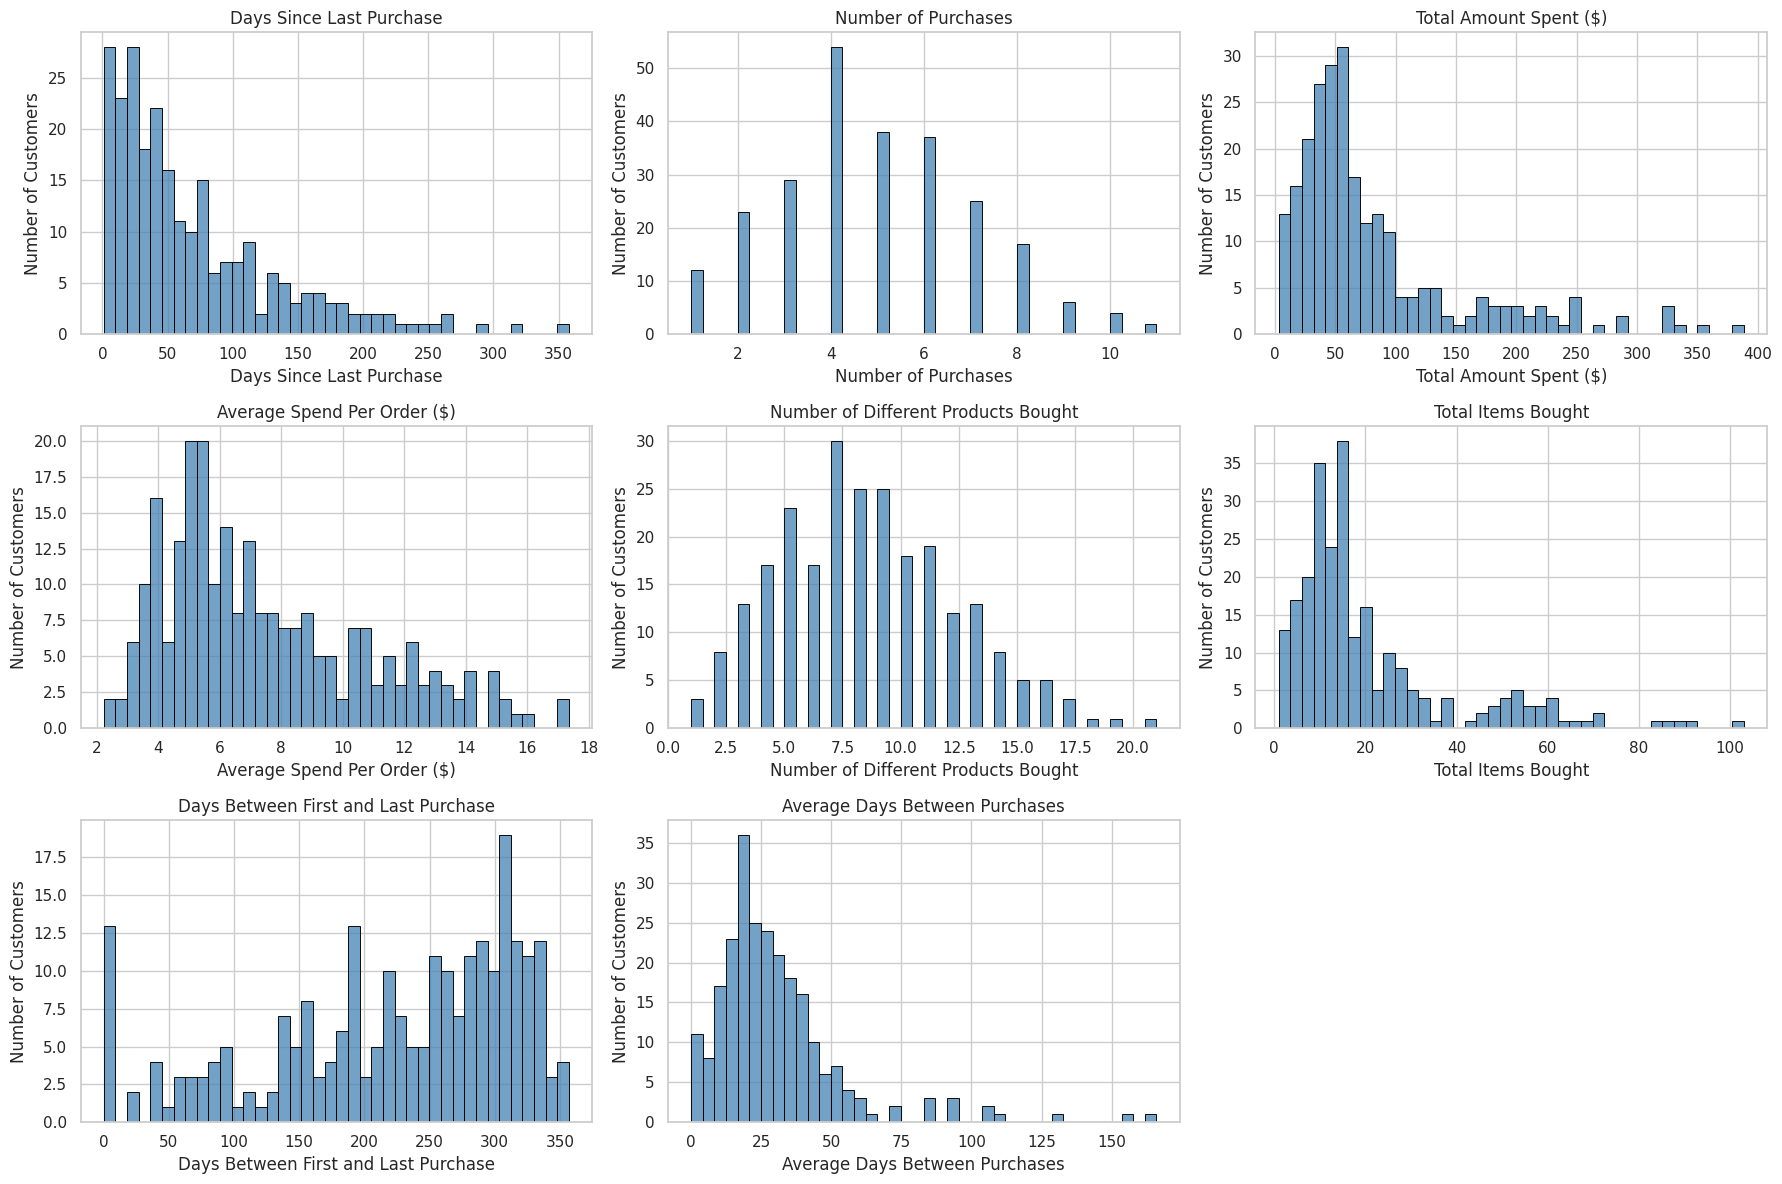

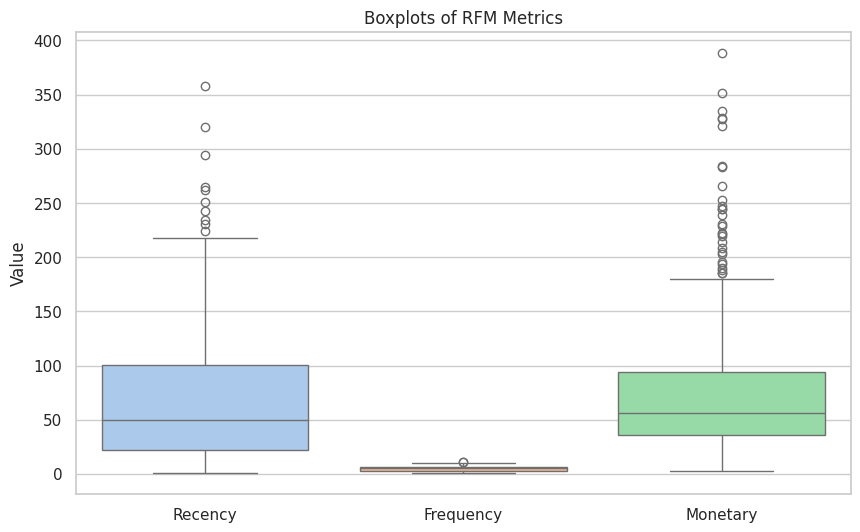

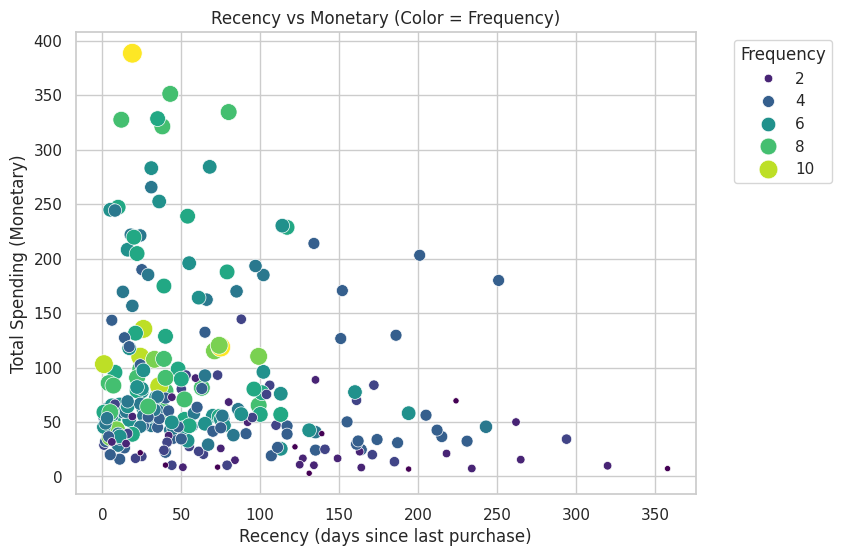

In [60]:
# Set style
sns.set(style="whitegrid")


# 1. Histograms for feature distributions

# Mapping column names to more readable titles for the charts
feature_titles = {
    "Recency": "Days Since Last Purchase",
    "Frequency": "Number of Purchases",
    "Monetary": "Total Amount Spent ($)",
    "AvgOrderValue": "Average Spend Per Order ($)",
    "ProductDiversity": "Number of Different Products Bought",
    "TotalQuantity": "Total Items Bought",
    "PurchaseSpan": "Days Between First and Last Purchase",
    "AvgDaysBetweenPurchases": "Average Days Between Purchases"
}

# Features to plot
features_to_plot = list(feature_titles.keys())



fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.histplot(rfm[feature], bins=40, kde=False, color='steelblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(feature_titles[feature])
    axes[i].set_xlabel(feature_titles[feature])
    axes[i].set_ylabel("Number of Customers")

# Hide any unused subplots
for j in range(len(features_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Boxplots to spot outliers in RFM core metrics

plt.figure(figsize=(10, 6))
sns.boxplot(data=rfm[["Recency", "Frequency", "Monetary"]], palette="pastel")
plt.title("Boxplots of RFM Metrics")
plt.ylabel("Value")
plt.show()



# Scatterplot: Recency vs Monetary

plt.figure(figsize=(8, 6))
sns.scatterplot(x="Recency", y="Monetary", data=rfm, hue="Frequency", palette="viridis", size="Frequency", sizes=(20, 200))
plt.title("Recency vs Monetary (Color = Frequency)")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Total Spending (Monetary)")
plt.legend(title="Frequency", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




Feature Scaling

In [61]:


# Features
clustering_features = [
    "Recency", "Frequency", "Monetary", "AvgOrderValue", "ProductDiversity",
    "TotalQuantity", "AvgQuantityPerTransaction", "CategoryDiversity",
    "PurchaseSpan", "AvgDaysBetweenPurchases"
]

# Keep only the columns we need
X = rfm[clustering_features].copy()

# Clean NaNs/Infs (common from gaps/averages)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Fill remaining NaNs with column medians
X = X.fillna(X.median(numeric_only=True))

# Outlier handling with IQR (column-wise)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Removing outliers using IQR...")
mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)

X_clean = X[mask].copy()
rfm_clean = rfm.loc[mask].copy()

print(f"Original data: {len(X)} customers")
print(f"After outlier removal: {len(X_clean)} customers")
print(f"Outliers removed: {len(X) - len(X_clean)} "
      f"({(len(X) - len(X_clean)) / len(X) * 100:.1f}%)")

# ---- 4) Scale features ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print("\nFeatures have been standardized (mean=0, std=1).")


Removing outliers using IQR...
Original data: 247 customers
After outlier removal: 181 customers
Outliers removed: 66 (26.7%)

Features have been standardized (mean=0, std=1).


Find Optimal K

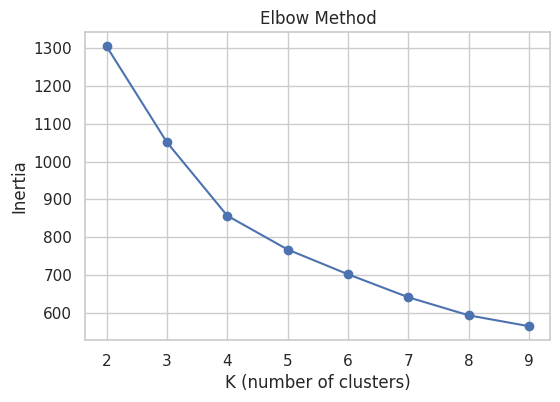

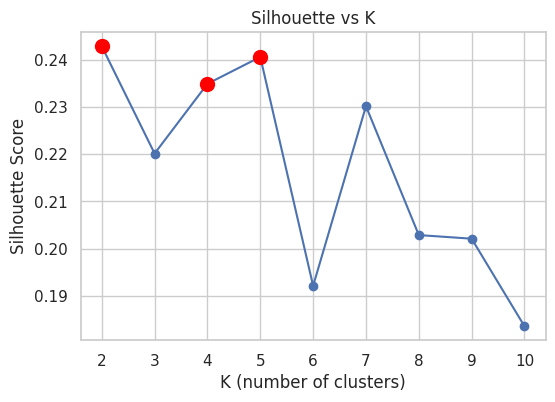

Ranked K values by silhouette score:
    K  Silhouette
0   2    0.242899
1   5    0.240630
2   4    0.234941
3   7    0.230194
4   3    0.220160
5   8    0.202878
6   9    0.202110
7   6    0.192116
8  10    0.183552
Top 3 K values: [2, 5, 4]


In [62]:
X_mat = X_scaled

# Find Optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_mat)
    inertia.append(km.inertia_)
    # Silhouette requires >1 cluster label
    sil = silhouette_score(X_mat, labels) if len(np.unique(labels)) > 1 else np.nan
    silhouette_scores.append(sil)


# Elbow plot
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), inertia, marker="o")
plt.xlabel("K (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


def top_k_by_silhouette(X_scaled, k_min=2, k_max=10, top_n=3, n_init=20, random_state=42, plot=True):
    """
    Returns a DataFrame of all K values ranked by silhouette score (descending),
    and a list of the top_n K values.
    """
    Ks = list(range(k_min, k_max + 1))
    sils = []

    for k in Ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels) if len(np.unique(labels)) > 1 else np.nan
        sils.append(sil)

    results = pd.DataFrame({"K": Ks, "Silhouette": sils})
    results_sorted = results.sort_values("Silhouette", ascending=False).reset_index(drop=True)

    top_k_values = results_sorted.head(top_n)["K"].tolist()

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(results["K"], results["Silhouette"], marker="o")
        plt.xlabel("K (number of clusters)")
        plt.ylabel("Silhouette Score")
        plt.title("Silhouette vs K")
        # Highlight top_n points
        for k_val in top_k_values:
            sil_val = results.loc[results["K"] == k_val, "Silhouette"].values[0]
            plt.scatter(k_val, sil_val, color='red', s=100, zorder=5)
        plt.show()

    return results_sorted, top_k_values


# Usage
results_df, top_k_list = top_k_by_silhouette(X_scaled, k_min=2, k_max=10, top_n=3, plot=True)
print("Ranked K values by silhouette score:")
print(results_df)
print(f"Top {len(top_k_list)} K values:", top_k_list)

Apply K-Means Clustering

In [63]:
# Apply K-Means with chosen K
optimal_k = 5  # set from your silhouette ranking,
kmeans = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    max_iter=300,
    n_init=20,
    random_state=42
)

# Fit on the scaled, filtered matrix
clusters = kmeans.fit_predict(X_scaled)  # len == len(rfm_clean)

# Add cluster labels to the filtered dataframe
rfm_clean = rfm_clean.copy()
rfm_clean["Cluster"] = clusters

# ----- Cluster centers back in original feature scale -----
# kmeans.cluster_centers_ are in scaled space; invert using the same scaler used on X_clean
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=clustering_features)
cluster_centers_df["Cluster"] = range(optimal_k)

print("Cluster Centers (Original Scale):")
print(cluster_centers_df.round(2).to_string(index=False))

# ----- Cluster sizes on the filtered set -----
cluster_sizes = rfm_clean["Cluster"].value_counts().sort_index()
print("\nCluster Sizes (filtered customers only):")
for cluster, size in cluster_sizes.items():
    pct = size / len(rfm_clean) * 100
    print(f"Cluster {cluster}: {size} customers ({pct:.1f}%)")

Cluster Centers (Original Scale):
 Recency  Frequency  Monetary  AvgOrderValue  ProductDiversity  TotalQuantity  AvgQuantityPerTransaction  CategoryDiversity  PurchaseSpan  AvgDaysBetweenPurchases  Cluster
   40.42       4.51     46.76           6.28              6.69          11.65                       1.53               4.97        265.31                    40.74        0
  123.55       4.82     51.54           6.03              7.64          13.45                       1.56               5.73        163.85                    21.97        1
   74.47       3.73    115.82          11.15              9.40          30.40                       2.94               6.67        207.40                    22.73        2
   35.08       7.35     80.05           5.98             11.02          20.46                       1.52               7.21        285.94                    23.50        3
  107.05       2.00     19.52           5.71              3.30           5.45                       1.54  

Visualize Clusters

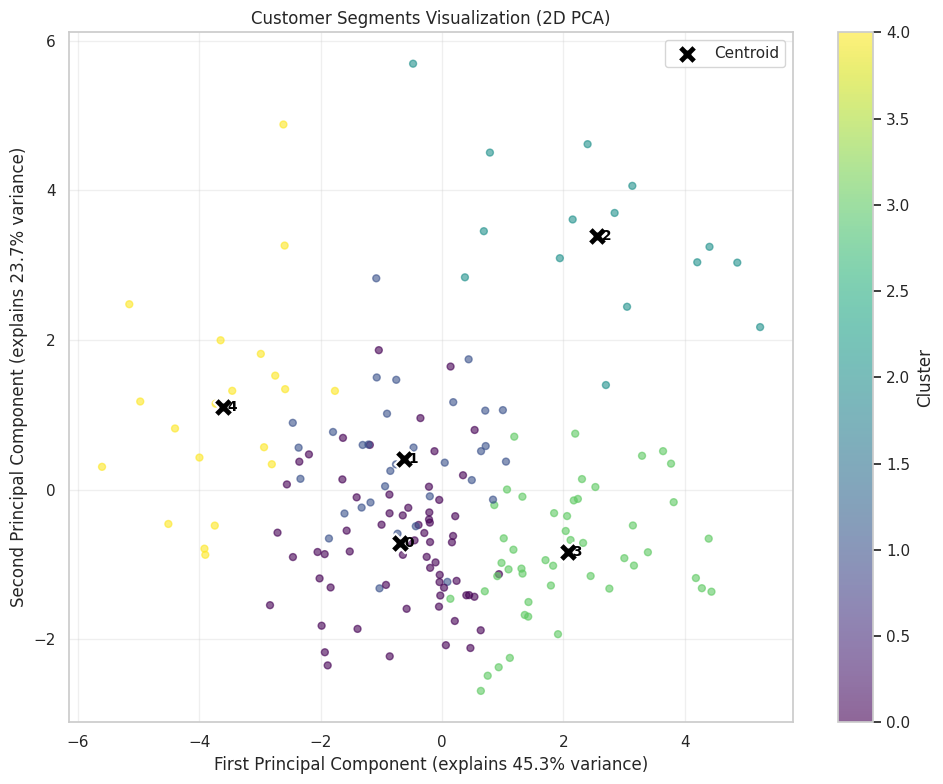

Total variance explained by 2 components: 69.0%


In [64]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter of customers
plt.figure(figsize=(10, 8))
sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=25)
plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Segments Visualization (2D PCA)')
plt.colorbar(sc, label='Cluster')
plt.grid(True, alpha=0.3)

# Optional: overlay K-Means centroids in the same PCA space if available
if 'kmeans' in globals():
    centroids_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
                marker='X', s=200, c='black', edgecolors='white', linewidths=1.5, label='Centroid')
    for i, (x, y) in enumerate(centroids_pca):
        plt.text(x, y, f" {i}", va="center", ha="left", fontsize=10, weight="bold", color="black")
    plt.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.1%}")

Analyze Cluster Characteristics

Average Values by Cluster:
         Recency  Frequency  Monetary  AvgOrderValue  ProductDiversity  \
Cluster                                                                  
0          40.42       4.51     46.76           6.28              6.69   
1         123.55       4.82     51.54           6.03              7.64   
2          74.47       3.73    115.82          11.15              9.40   
3          35.08       7.35     80.05           5.98             11.02   
4         107.05       2.00     19.52           5.71              3.30   

         TotalQuantity  AvgQuantityPerTransaction  CategoryDiversity  \
Cluster                                                                
0                11.65                       1.53               4.97   
1                13.45                       1.56               5.73   
2                30.40                       2.94               6.67   
3                20.46                       1.52               7.21   
4                 5.45

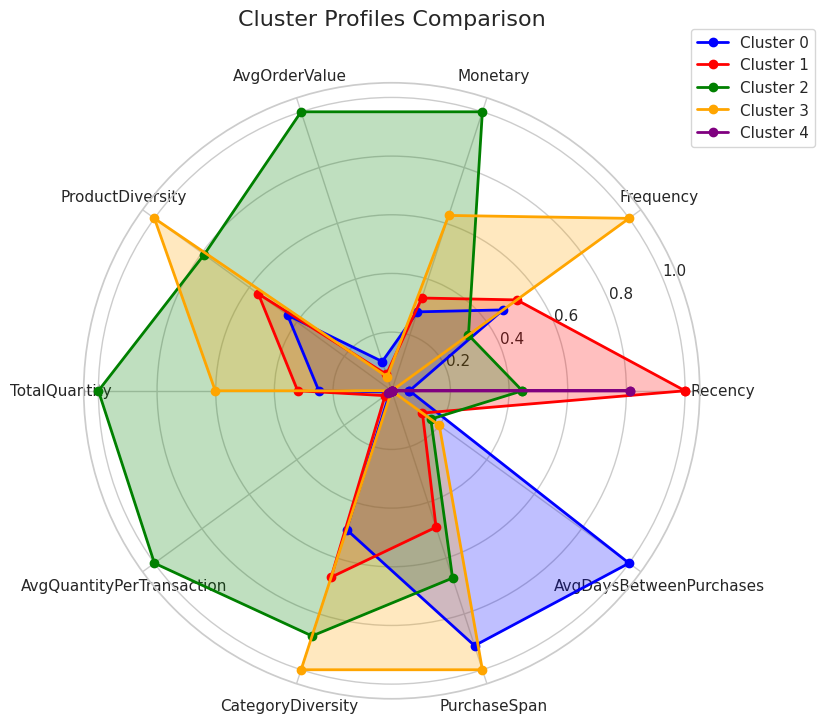

In [65]:
# Calculate cluster profiles
cluster_profiles = rfm_clean.groupby('Cluster')[clustering_features].mean().round(2)
print("Average Values by Cluster:")
print(cluster_profiles)

# Create radar chart for cluster comparison
from math import pi

# Normalize cluster profiles for radar chart
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Set up radar chart
categories = clustering_features
fig = plt.figure(figsize=(12, 8))

# Number of variables
num_vars = len(categories)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the plot
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories)

# Plot each cluster
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for idx, row in cluster_profiles_normalized.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {idx}', color=colors[idx])
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.title('Cluster Profiles Comparison', size=16, y=1.08)
plt.show()

Create Customer Personas

In [66]:
# Persona classifier based on cluster averages (cluster_profiles is your
# groupby('Cluster').mean() table; cluster_sizes is value_counts of labels)

def create_persona(cluster_row):
    r = cluster_row["Recency"]                    # days since last purchase (lower = more recent)
    f = cluster_row["Frequency"]                  # number of purchases
    m = cluster_row["Monetary"]                   # total spend
    aov = cluster_row["AvgOrderValue"]            # average spend per order
    prod_div = cluster_row["ProductDiversity"]    # unique products
    cat_div = cluster_row["CategoryDiversity"]    # unique categories
    qty_total = cluster_row["TotalQuantity"]      # total items
    qty_per_txn = cluster_row["AvgQuantityPerTransaction"]
    span = cluster_row["PurchaseSpan"]            # days between first and last purchase
    gap = cluster_row["AvgDaysBetweenPurchases"]  # avg days between orders

    # 1) Loyal, frequent shoppers (very recent, many orders, long relationship, broad variety)
    if (r <= 45) and (f >= 6) and (span >= 240) and (prod_div >= 9 or cat_div >= 6):
        return ("Loyal Frequent Shoppers",
                "Very engaged customers who buy often, purchase a wide range of items, and have a long relationship.")

    # 2) Bulk, high-spend buyers (large baskets, higher total spend, higher qty per order)
    if (m >= 90) and (qty_total >= 25) and (qty_per_txn >= 2.5):
        return ("Bulk High-Spend Buyers",
                "Big baskets and higher spend; likely stocking up. Great candidates for bundles and subscriptions.")

    # 3) Steady long-term buyers (recent enough, moderate frequency/spend, long span)
    if (r <= 90) and (3 <= f <= 6) and (span >= 200):
        return ("Steady Long-Term Buyers",
                "Reliable, moderate spenders who return over many months. Maintain with loyalty perks and light promos.")

    # 4) Variety seekers, less recent (haven’t bought lately but try many different items/categories)
    if (r >= 100) and (3 <= f <= 6) and (prod_div >= 7 or cat_div >= 5):
        return ("Variety Seekers (Lapsed)",
                "Not active recently but sample many items when they shop. Reactivate with try-something-new offers.")

    # 5) One-off, low-spend buyers (infrequent, low spend, short span)
    if (f <= 2) and (m < 35) and (span <= 90):
        return ("One-Off Low-Spend Buyers",
                "Low engagement and low spend. Use low-cost win-back or focus budget elsewhere unless behavior changes.")

    # Fallback if a cluster doesn’t fit neatly
    return ("Emerging/Potential Loyalists",
            "Showing promise; nurture with personalized recommendations and loyalty nudges.")

# Build personas for each cluster from your summaries
personas = {}
for cluster_id, row in cluster_profiles.iterrows():
    name, desc = create_persona(row)
    personas[cluster_id] = {
        "name": name,
        "description": desc,
        "size": int(cluster_sizes.get(cluster_id, 0)),
        "metrics": {k: float(v) for k, v in row.to_dict().items()}
    }

# Pretty print
print("CUSTOMER PERSONAS BY CLUSTER")
print("=" * 50)
for cid, p in personas.items():
    print(f"\nCluster {cid}: {p['name']}")
    print(f"Description: {p['description']}")
    print(f"Size: {p['size']} customers")
    print("Key Metrics (cluster means):")
    for k, v in p["metrics"].items():
        print(f"  - {k}: {v:.2f}")


CUSTOMER PERSONAS BY CLUSTER

Cluster 0: Steady Long-Term Buyers
Description: Reliable, moderate spenders who return over many months. Maintain with loyalty perks and light promos.
Size: 65 customers
Key Metrics (cluster means):
  - Recency: 40.42
  - Frequency: 4.51
  - Monetary: 46.76
  - AvgOrderValue: 6.28
  - ProductDiversity: 6.69
  - TotalQuantity: 11.65
  - AvgQuantityPerTransaction: 1.53
  - CategoryDiversity: 4.97
  - PurchaseSpan: 265.31
  - AvgDaysBetweenPurchases: 40.74

Cluster 1: Variety Seekers (Lapsed)
Description: Not active recently but sample many items when they shop. Reactivate with try-something-new offers.
Size: 33 customers
Key Metrics (cluster means):
  - Recency: 123.55
  - Frequency: 4.82
  - Monetary: 51.54
  - AvgOrderValue: 6.03
  - ProductDiversity: 7.64
  - TotalQuantity: 13.45
  - AvgQuantityPerTransaction: 1.56
  - CategoryDiversity: 5.73
  - PurchaseSpan: 163.85
  - AvgDaysBetweenPurchases: 21.97

Cluster 2: Bulk High-Spend Buyers
Description: Big ba

Alternate Clustering Method: Hierarchial Clustering

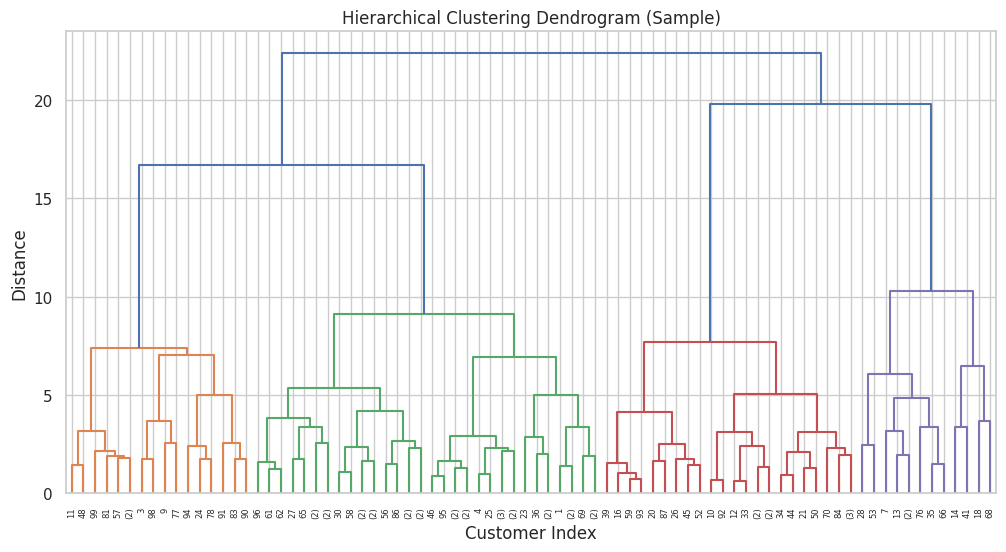


Similarity between K-Means and Hierarchical Clustering: 0.41
(1.0 = identical, 0.0 = random)


In [67]:

# Apply Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix
# Sample data for dendrogram (full dataset would be too large to visualize)
sample_indices = np.random.choice(len(X_scaled), size=min(100, len(X_scaled)), replace=False)
X_sample = X_scaled[sample_indices]

# Perform hierarchical clustering
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=6)
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

# Apply Agglomerative Clustering on full dataset
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k)
agg_clusters = agg_clustering.fit_predict(X_scaled)

# Compare with K-Means
from sklearn.metrics import adjusted_rand_score
similarity = adjusted_rand_score(clusters, agg_clusters)
print(f"\nSimilarity between K-Means and Hierarchical Clustering: {similarity:.2f}")
print("(1.0 = identical, 0.0 = random)")

Gaussian Mixture Model (GMM)

In [69]:


# --- Fit Gaussian Mixture Model ---
gmm = GaussianMixture(n_components=optimal_k, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# --- Silhouette score ---
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)
print(f"Gaussian Mixture silhouette (k={optimal_k}): {gmm_silhouette:.3f}")

# --- Compare with K-Means and Agglomerative ---
ari_kmeans = adjusted_rand_score(clusters, gmm_labels)
ari_agglo = adjusted_rand_score(agg_clusters, gmm_labels)
print(f"Similarity GMM vs KMeans (ARI): {ari_kmeans:.3f}")
print(f"Similarity GMM vs Agglomerative (ARI): {ari_agglo:.3f}")

# --- GMM Cluster means (original scale) ---
gmm_cluster_means = pd.DataFrame(X_clean, columns=clustering_features)
gmm_cluster_means['Cluster_GMM'] = gmm_labels
gmm_means = gmm_cluster_means.groupby('Cluster_GMM')[clustering_features].mean().round(1)

print("\nGaussian Mixture Cluster Averages (key metrics):")
print(gmm_means[['Recency', 'Frequency', 'Monetary']])

# --- Quick persona-style summary ---
print("\nQuick Persona-style Summary (GMM):")
for c, row in gmm_means[['Recency', 'Frequency', 'Monetary']].iterrows():
    print(f"  Cluster {c}: Recency={row['Recency']}, "
          f"Freq={row['Frequency']}, Spend={row['Monetary']}")


Gaussian Mixture silhouette (k=5): 0.151
Similarity GMM vs KMeans (ARI): 0.407
Similarity GMM vs Agglomerative (ARI): 0.485

Gaussian Mixture Cluster Averages (key metrics):
             Recency  Frequency  Monetary
Cluster_GMM                              
0               58.4        5.6      56.0
1               52.8        4.1      44.6
2               44.2        7.7      89.6
3               74.5        3.7     115.8
4              111.1        2.6      24.8

Quick Persona-style Summary (GMM):
  Cluster 0: Recency=58.4, Freq=5.6, Spend=56.0
  Cluster 1: Recency=52.8, Freq=4.1, Spend=44.6
  Cluster 2: Recency=44.2, Freq=7.7, Spend=89.6
  Cluster 3: Recency=74.5, Freq=3.7, Spend=115.8
  Cluster 4: Recency=111.1, Freq=2.6, Spend=24.8


Comparing all 3 Clustering Methods

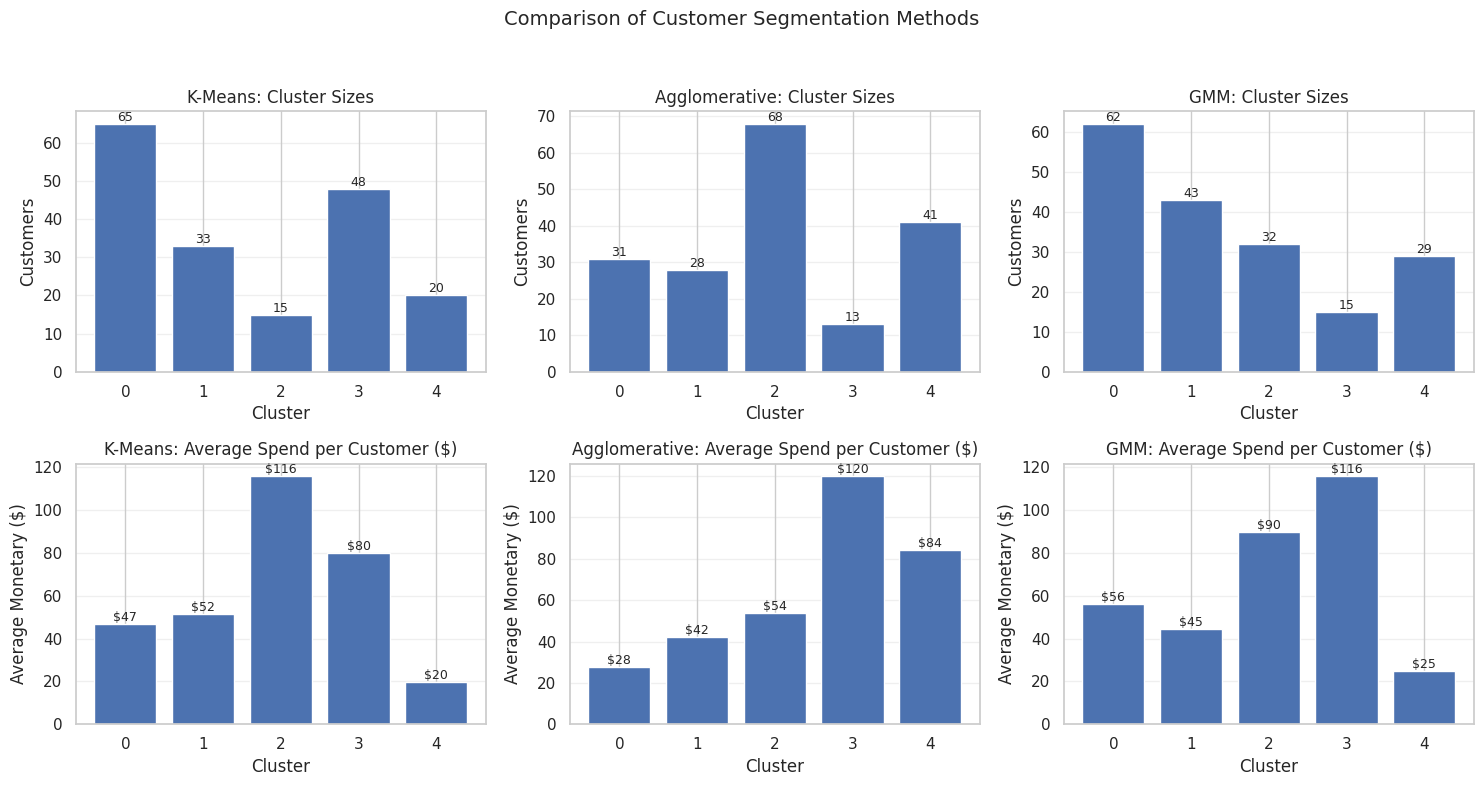

In [72]:

# --- Inputs assumed to exist ---
# clusters      -> K-Means labels (len = len(rfm_clean))
# agg_labels    -> Agglomerative labels (len = len(rfm_clean))
# gmm_labels    -> GMM labels (len = len(rfm_clean))
# rfm_clean     -> DataFrame of customers used for clustering
#                  with at least the column "Monetary"

# Put methods into a dict for easy looping
methods = {
    "K-Means": np.asarray(clusters),
    "Agglomerative": np.asarray(agg_clusters),
    "GMM": np.asarray(gmm_labels),
}

# Helper to get ordered unique labels (0..k-1 if possible)
def ordered_labels(labels):
    labs = np.unique(labels)
    # sort numerically for readability
    return np.sort(labs)

# Compute per-method cluster sizes and monetary means
summary = {}
for name, labs in methods.items():
    # Cluster sizes
    sizes = pd.Series(labs).value_counts().sort_index()
    # Monetary means by cluster (original scale)
    tmp = rfm_clean.copy()
    tmp["_label"] = labs
    means = tmp.groupby("_label")["Monetary"].mean().sort_index()
    summary[name] = {"sizes": sizes, "monetary_means": means}

# --- Plot: one figure, 2 rows x 3 columns ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Comparison of Customer Segmentation Methods", fontsize=14)

method_names = list(methods.keys())

# Row 1: Cluster sizes
for j, name in enumerate(method_names):
    ax = axes[0, j]
    sizes = summary[name]["sizes"]
    bars = ax.bar(sizes.index.astype(str), sizes.values)
    ax.set_title(f"{name}: Cluster Sizes")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Customers")
    ax.grid(axis="y", alpha=0.3)
    # labels on bars
    for b in bars:
        ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
                ha="center", va="bottom", fontsize=9)

# Row 2: Average Monetary per cluster
for j, name in enumerate(method_names):
    ax = axes[1, j]
    means = summary[name]["monetary_means"].round(1)
    bars = ax.bar(means.index.astype(str), means.values)
    ax.set_title(f"{name}: Average Spend per Customer ($)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Average Monetary ($)")
    ax.grid(axis="y", alpha=0.3)
    # labels on bars
    for b, val in zip(bars, means.values):
        ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"${val:.0f}",
                ha="center", va="bottom", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [74]:



def evaluate_segmentations(X_scaled, rfm_clean, k=5, random_state=42,
                           weights=None, return_labels=False):
    """
    Fit KMeans, Agglomerative, GMM with the same k and rank them.
    weights: dict with keys ['sil', 'ch', 'db', 'mon'] that sum to 1.0
    return_labels: if True, also returns dict of labels per method
    """
    if weights is None:
        # Emphasize silhouette and business value (monetary separation)
        weights = {'sil': 0.4, 'ch': 0.2, 'db': 0.2, 'mon': 0.2}

    # --- Fit models ---
    km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
    km_labels = km.fit_predict(X_scaled)

    agg = AgglomerativeClustering(n_clusters=k, linkage="ward", metric="euclidean")
    agg_labels = agg.fit_predict(X_scaled)

    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state)
    gmm_labels = gmm.fit_predict(X_scaled)

    methods = {
        "K-Means": km_labels,
        "Agglomerative": agg_labels,
        "GMM": gmm_labels
    }

    # --- Helper: monetary separation ---
    money = rfm_clean["Monetary"].values
    def mon_sep(labels):
        means = [money[labels == c].mean() for c in np.unique(labels)]
        return float(np.max(means) - np.min(means))

    # --- Raw metrics per method ---
    rows = []
    for name, y in methods.items():
        sil = silhouette_score(X_scaled, y)
        ch = calinski_harabasz_score(X_scaled, y)
        db = davies_bouldin_score(X_scaled, y)
        ms = mon_sep(y)
        rows.append([name, sil, ch, db, ms])

    df = pd.DataFrame(rows, columns=["Method", "Silhouette", "CalinskiHarabasz", "DaviesBouldin", "MonetarySeparation"])

    # --- Normalize to 0-1 for combining ---
    def norm_pos(x):  # higher is better
        return (x - x.min()) / (x.max() - x.min() + 1e-12)

    def norm_neg(x):  # lower is better
        return (x.max() - x.min() - (x - x.min())) / (x.max() - x.min() + 1e-12)

    df["sil_n"] = norm_pos(df["Silhouette"])
    df["ch_n"]  = norm_pos(df["CalinskiHarabasz"])
    df["db_n"]  = norm_neg(df["DaviesBouldin"])
    df["mon_n"] = norm_pos(df["MonetarySeparation"])

    # Weighted final score
    df["FinalScore"] = (
        weights['sil'] * df["sil_n"] +
        weights['ch']  * df["ch_n"]  +
        weights['db']  * df["db_n"]  +
        weights['mon'] * df["mon_n"]
    )

    # Keep just readable columns
    out = (df[["Method", "Silhouette", "CalinskiHarabasz", "DaviesBouldin", "MonetarySeparation", "FinalScore"]]
           .sort_values("FinalScore", ascending=False)
           .reset_index(drop=True)
           .round({"Silhouette": 3, "CalinskiHarabasz": 1, "DaviesBouldin": 3, "MonetarySeparation": 2, "FinalScore": 3}))

    # --- Pairwise ARI for context (optional print) ---
    ari_km_agg  = adjusted_rand_score(km_labels, agg_labels)
    ari_km_gmm  = adjusted_rand_score(km_labels, gmm_labels)
    ari_agg_gmm = adjusted_rand_score(agg_labels, gmm_labels)

    print("Pairwise ARI (agreement between methods):")
    print(f"  K-Means vs Agglomerative: {ari_km_agg:.3f}")
    print(f"  K-Means vs GMM:           {ari_km_gmm:.3f}")
    print(f"  Agglomerative vs GMM:     {ari_agg_gmm:.3f}\n")

    print("Clustering Method Comparison (ranked):")
    print(out.to_string(index=False))

    if return_labels:
        return out, {"K-Means": km_labels, "Agglomerative": agg_labels, "GMM": gmm_labels}
    return out

# ---- Run it ----
results = evaluate_segmentations(X_scaled, rfm_clean, k=5, random_state=42)



Pairwise ARI (agreement between methods):
  K-Means vs Agglomerative: 0.408
  K-Means vs GMM:           0.407
  Agglomerative vs GMM:     0.485

Clustering Method Comparison (ranked):
       Method  Silhouette  CalinskiHarabasz  DaviesBouldin  MonetarySeparation  FinalScore
      K-Means       0.241              59.9          1.305               96.30       1.000
Agglomerative       0.165              50.4          1.527               92.05       0.141
          GMM       0.151              53.0          1.585               91.01       0.054


Market Basket Analysis with Apriori Algorithm

Basket built with product column: ProductName
Shape: 1200 invoices × 28 products
Frequent itemsets: 37 | Rules: 12

Rules (filtered view, top by lift):
      antecedents consequents   support  confidence      lift  leverage  \
0         [Sugar]    [Coffee]  0.034167    0.455556  4.795322  0.027042   
1        [Coffee]     [Sugar]  0.034167    0.359649  4.795322  0.027042   
2       [Creamer]    [Coffee]  0.034167    0.431579  4.542936  0.026646   
3        [Coffee]   [Creamer]  0.034167    0.359649  4.542936  0.026646   
4        [Butter]     [Bread]  0.033333    0.449438  4.148660  0.025299   
5         [Bread]    [Butter]  0.033333    0.307692  4.148660  0.025299   
6  [Tomato Sauce]     [Pasta]  0.024167    0.402778  3.689567  0.017617   
7           [Jam]     [Bread]  0.029167    0.357143  3.296703  0.020319   
8          [Soda]     [Chips]  0.032500    0.364486  3.216053  0.022394   
9  [Garlic Bread]     [Pasta]  0.027500    0.351064  3.215852  0.018949   

   conviction  
0    1

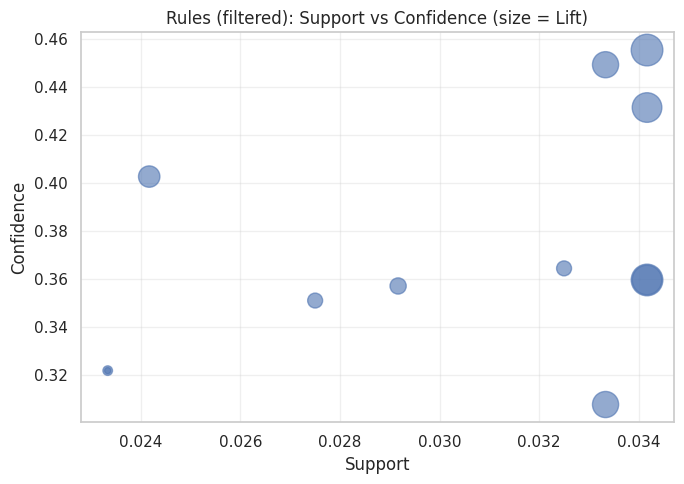

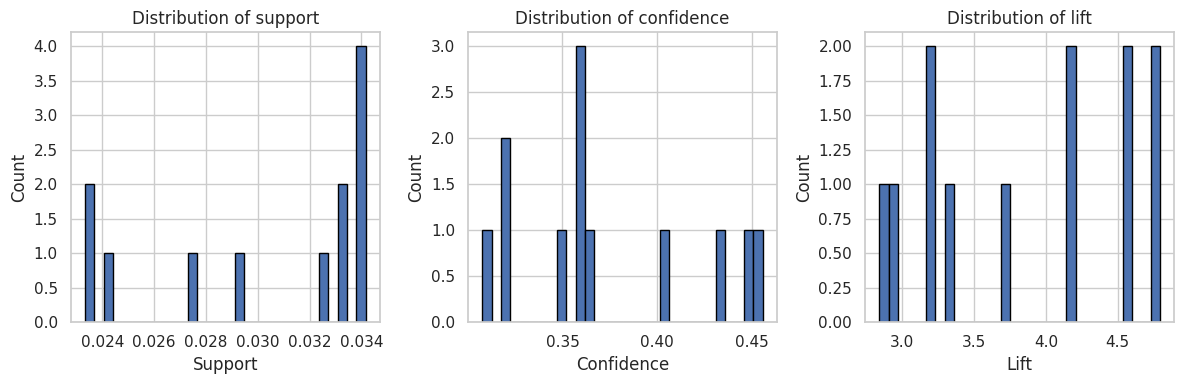

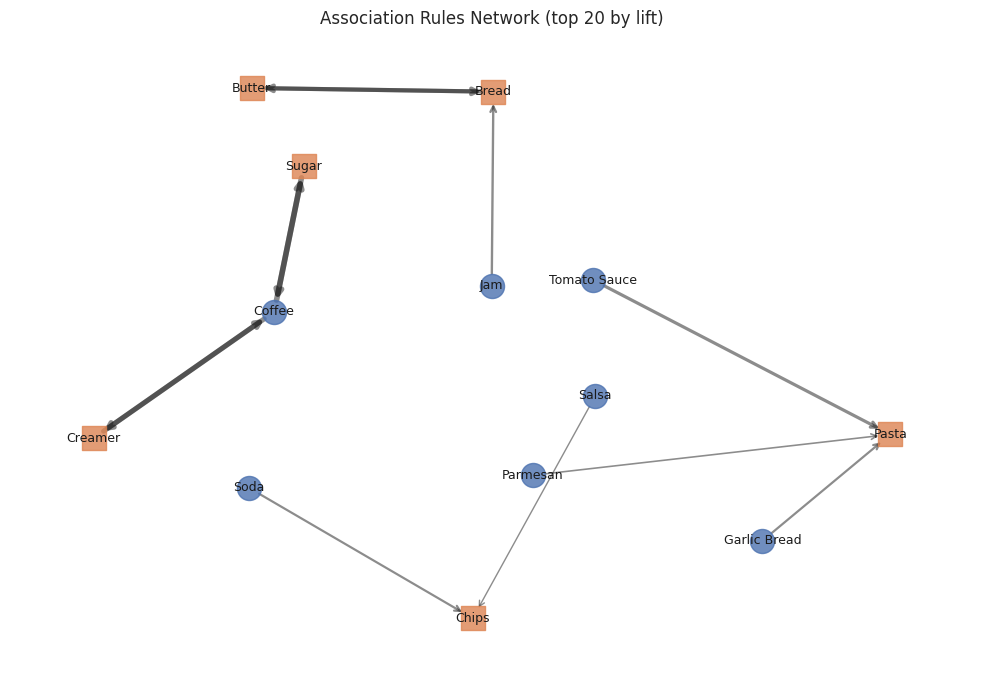

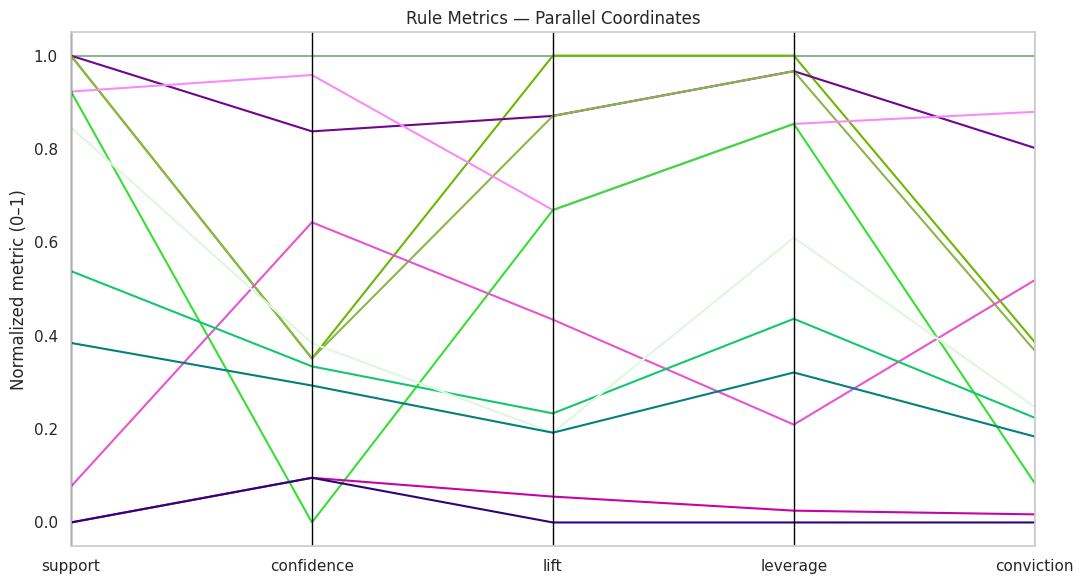

In [78]:
"""
Market Basket Analysis (Apriori) — Explorer, Recommender, and Visualizations
Notebook-friendly (matplotlib + optional networkx).

What you get in this single cell:
1) Basket builder (invoices × products, boolean).
2) Apriori frequent itemsets and association rules (rubric-ready thresholds).
3) Rules explorer with filters (support, confidence, lift, length, include/exclude items).
4) Product recommendation engine (enter products → ranked consequents).
5) Visuals: scatter (support vs confidence, size=lift), histograms, network graph, parallel coordinates.

Assumes you already have either `df` or `df_clean` in memory with columns:
InvoiceNo, Quantity, and one of [ProductName, Description, ProductID].
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules

# Optional (for the network graph)
try:
    import networkx as nx
    HAS_NX = True
except Exception:
    HAS_NX = False

# ----------------------------- Parameters ------------------------------------
MIN_SUPPORT = 0.02   # rubric: 0.01–0.05
MIN_CONF    = 0.30   # rubric: 0.25–0.50
MIN_LIFT    = 1.10   # mild strength screen for exploration

# ---------------------- 1) Basket builder (boolean) --------------------------
def build_boolean_basket(df_in, product_col=None):
    """
    Build a boolean basket: rows=invoices, cols=products, values=0/1.
    Assumes df_in has ['InvoiceNo', 'Quantity'] and a product column.
    """
    # Choose product column if not specified
    if product_col is None:
        for c in ["ProductName", "Description", "ProductID"]:
            if c in df_in.columns:
                product_col = c
                break
        if product_col is None:
            raise ValueError("Expected a product column: ProductName or Description or ProductID")

    sub = df_in.loc[:, ["InvoiceNo", product_col, "Quantity"]].copy()
    sub = sub.dropna(subset=["InvoiceNo", product_col, "Quantity"])
    sub["Quantity"] = pd.to_numeric(sub["Quantity"], errors="coerce")
    sub = sub.dropna(subset=["Quantity"])
    sub = sub[sub["Quantity"] > 0]  # ignore returns/free items

    basket = (
        sub.groupby(["InvoiceNo", product_col])["Quantity"]
           .sum()
           .unstack(fill_value=0)
    )
    basket_bool = basket.gt(0)  # True/False presence
    return basket_bool, product_col

# ------------------ 2) Mine itemsets and association rules -------------------
def mine_rules(basket_bool, min_support=MIN_SUPPORT, min_conf=MIN_CONF, sort_by=("lift","confidence")):
    """
    Run Apriori on the boolean basket and build association rules.
    Returns a tidy rules DataFrame with readable antecedents/consequents (lists).
    """
    itemsets = apriori(basket_bool, min_support=min_support, use_colnames=True)
    rules = association_rules(itemsets, metric="confidence", min_threshold=min_conf)
    # Keep rubric-aligned prevalence as well
    rules = rules.query("support >= @min_support").copy()

    # Readable lists instead of frozensets
    rules["antecedents"] = rules["antecedents"].apply(lambda s: list(s))
    rules["consequents"] = rules["consequents"].apply(lambda s: list(s))

    # Helpful diagnostics
    rules["antecedent_len"] = rules["antecedents"].apply(len)
    rules["consequent_len"] = rules["consequents"].apply(len)

    # Sort
    rules = rules.sort_values(list(sort_by), ascending=False).reset_index(drop=True)
    return rules, itemsets

# ---------------------- 3) Rules explorer (filtering) ------------------------
def filter_rules(rules_df, include=None, exclude=None,
                 min_support=MIN_SUPPORT, min_conf=MIN_CONF, min_lift=MIN_LIFT,
                 max_antecedent_len=None, top_n=50):
    """
    Filter and rank rules.
    - include: items that must all appear in the antecedent (subset match)
    - exclude: items that must NOT appear anywhere in the rule
    - max_antecedent_len: cap the size of the antecedent
    """
    r = rules_df.copy()
    # Numeric thresholds
    r = r[(r["support"] >= min_support) & (r["confidence"] >= min_conf) & (r["lift"] >= min_lift)]
    # Length filter
    if max_antecedent_len is not None:
        r = r[r["antecedent_len"] <= int(max_antecedent_len)]
    # Include and exclude
    if include:
        inc = set(include)
        r = r[r["antecedents"].apply(lambda ants: inc.issubset(set(ants)))]
    if exclude:
        exc = set(exclude)
        r = r[~r["antecedents"].apply(lambda ants: bool(set(ants) & exc))]
        r = r[~r["consequents"].apply(lambda cons: bool(set(cons) & exc))]
    # Rank by lift then confidence
    r = r.sort_values(["lift","confidence","support"], ascending=False)
    return r.head(top_n)

# --------------- 4) Product recommendation engine from rules -----------------
def recommend_from_rules(products, rules_df, top_n=10):
    """
    Given a set/list of products already in a basket:
    - Find rules where antecedents ⊆ products
    - Rank by lift then confidence
    - Exclude items already present
    """
    prods = set(products)
    if not prods:
        return pd.DataFrame(columns=["consequent","support","confidence","lift"])
    mask = rules_df["antecedents"].apply(lambda ants: set(ants).issubset(prods))
    recs = (rules_df[mask][["consequents","support","confidence","lift"]]
                .explode("consequents")
                .rename(columns={"consequents":"consequent"}))
    recs = recs[~recs["consequent"].isin(prods)]
    recs = recs.sort_values(["lift","confidence","support"], ascending=False).head(top_n)
    return recs.reset_index(drop=True)

# ------------------------------ 5) Visuals -----------------------------------
def plot_rules_scatter(rules_df, title="Rules: Support vs Confidence (size = Lift)"):
    """Scatter of support vs. confidence; bubble size encodes lift."""
    if rules_df.empty:
        print("No rules to plot.")
        return
    r = rules_df.copy()
    sizes = 500 * (r["lift"] - r["lift"].min()) / (r["lift"].max() - r["lift"].min() + 1e-12) + 20
    plt.figure(figsize=(7,5))
    plt.scatter(r["support"], r["confidence"], s=sizes, alpha=0.6)
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_rules_histograms(rules_df):
    """Histograms of support, confidence, and lift."""
    if rules_df.empty:
        print("No rules to plot.")
        return
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    for ax, col in zip(axes, ["support","confidence","lift"]):
        ax.hist(rules_df[col].values, bins=30, edgecolor="black")
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col.capitalize()); ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

def draw_rules_network(rules_df, top_n=25, title="Association Rules Network (top by lift)"):
    """
    Network graph of top-N rules by lift.
    Nodes represent the ENTIRE antecedent set and ENTIRE consequent set as grouped labels
    (compact representation). Directed edges weighted by lift.
    """
    if not HAS_NX:
        print("networkx not installed; skipping network graph.")
        return
    if rules_df.empty:
        print("No rules to visualize.")
        return
    r = rules_df.sort_values(["lift","confidence"], ascending=False).head(top_n).copy()

    # Build graph
    G = nx.DiGraph()
    # Normalize labels for nodes (join items with ' + ')
    def lbl(items): return " + ".join(map(str, items))
    for _, row in r.iterrows():
        a = lbl(row["antecedents"])
        c = lbl(row["consequents"])
        w = float(row["lift"])
        G.add_node(a, kind="antecedent")
        G.add_node(c, kind="consequent")
        G.add_edge(a, c, lift=w, support=float(row["support"]), confidence=float(row["confidence"]))

    # Layout and drawing
    pos = nx.spring_layout(G, k=0.8, seed=42)
    plt.figure(figsize=(10, 7))
    # Edge widths scaled by lift
    lifts = np.array([d["lift"] for _,_,d in G.edges(data=True)])
    if len(lifts) == 0:
        print("No edges to draw.")
        return
    widths = 1.0 + 3.0 * (lifts - lifts.min()) / (lifts.max() - lifts.min() + 1e-12)

    # Draw nodes
    kinds = nx.get_node_attributes(G, "kind")
    nodes_a = [n for n,k in kinds.items() if k=="antecedent"]
    nodes_c = [n for n,k in kinds.items() if k=="consequent"]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_a, node_shape="o", node_color="#4c72b0", alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_c, node_shape="s", node_color="#dd8452", alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=widths, arrows=True, arrowstyle="->", alpha=0.5)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

from pandas.plotting import parallel_coordinates

def plot_rules_parallel_coords(rules_df, top_n=25, title="Rule Metrics — Parallel Coordinates"):
    """
    Parallel coordinates for rule metrics: support, confidence, lift, leverage, conviction.
    Plots top-N rules by lift (to keep the chart readable).
    """
    if rules_df.empty:
        print("No rules to plot.")
        return

    cols = [c for c in ["support","confidence","lift","leverage","conviction"] if c in rules_df.columns]
    if not cols:
        print("Required metric columns not found for parallel coordinates.")
        return

    r = rules_df.sort_values("lift", ascending=False).head(top_n).copy()

    # Build a human-readable rule label
    def make_label(row):
        a = " + ".join(map(str, row["antecedents"]))
        c = " + ".join(map(str, row["consequents"]))
        return f"{a} → {c}"
    r["rule_label"] = r.apply(make_label, axis=1)
    plot_df = r[["rule_label"] + cols].copy()

    # Normalize 0–1 per column for readability
    for c in cols:
        v = plot_df[c].values.astype(float)
        lo, hi = np.nanmin(v), np.nanmax(v)
        plot_df[c] = (v - lo) / (hi - lo + 1e-12)

    plt.figure(figsize=(11, 6))
    parallel_coordinates(plot_df, "rule_label", color=None, linewidth=1.5)
    plt.title(title)
    plt.ylabel("Normalized metric (0–1)")
    plt.xticks(rotation=0)
    plt.legend([], [], frameon=False)  # hide long legend for readability
    plt.tight_layout()
    plt.show()

# --------------------------- 6) Run the pipeline -----------------------------
# Pick a source DataFrame that exists
if 'df' in globals():
    source_df = df
elif 'df_clean' in globals():
    source_df = df_clean
else:
    raise NameError("No dataframe named 'df' or 'df_clean' is defined in this session.")

# Build basket from the chosen dataframe
basket_bool, PRODUCT_COL = build_boolean_basket(source_df)
print(f"Basket built with product column: {PRODUCT_COL}")
print(f"Shape: {basket_bool.shape[0]} invoices × {basket_bool.shape[1]} products")

# Mine rules once with your rubric defaults
rules_all, frequent_itemsets = mine_rules(
    basket_bool,
    min_support=MIN_SUPPORT,
    min_conf=MIN_CONF,
    sort_by=("lift", "confidence")
)
print(f"Frequent itemsets: {len(frequent_itemsets)} | Rules: {len(rules_all)}")

# Explorer view (adjust thresholds/items as needed)
rules_view = filter_rules(
    rules_all,
    include=None,                 # e.g., {"Pasta"}
    exclude=None,                 # e.g., {"Gift Card"}
    min_support=MIN_SUPPORT,
    min_conf=MIN_CONF,
    min_lift=MIN_LIFT,
    max_antecedent_len=3,
    top_n=25
)
cols_to_show = [c for c in ["antecedents","consequents","support","confidence","lift","leverage","conviction"]
                if c in rules_view.columns]
print("\nRules (filtered view, top by lift):")
print(rules_view[cols_to_show].head(10))

# Visuals
plot_rules_scatter(rules_view, title="Rules (filtered): Support vs Confidence (size = Lift)")
plot_rules_histograms(rules_view)
draw_rules_network(rules_view, top_n=20, title="Association Rules Network (top 20 by lift)")
plot_rules_parallel_coords(rules_view, top_n=20)

# Example: product recommendations (uncomment to use)
# recs = recommend_from_rules({"Pasta", "Tomato Sauce"}, rules_all, top_n=10)
# print("\nRecommendations for basket {Pasta, Tomato Sauce}:")
# print(recs)



Visualizations

In [79]:
# --- Sizes and AOV by cluster (for the write-up) ---
sizes = rfm_clean["Cluster"].value_counts().sort_index()
aov_by_cluster = rfm_clean.groupby("Cluster")["AvgOrderValue"].mean().round(2)
print("Cluster sizes:\n", sizes, "\n")
print("Average order value by cluster:\n", aov_by_cluster, "\n")

# --- Pull top rules to mention in the report (by lift) ---
def top_rule_strings(rules_df, n=5):
    r = rules_df.sort_values(["lift","confidence"], ascending=False).head(n)
    out = []
    for _, row in r.iterrows():
        a = ", ".join(map(str, row["antecedents"]))
        c = ", ".join(map(str, row["consequents"]))
        out.append(f"{a} ⇒ {c}  (support={row['support']:.2%}, conf={row['confidence']:.2%}, lift={row['lift']:.2f})")
    return out

print("Top rules to cite:")
for s in top_rule_strings(rules_view, n=5):
    print(" -", s)

# --- Quick ROI projection for top-N rules ---
# Assumptions you can tune:
MARGIN = 0.35          # gross margin on consequents
ELIGIBLE_BASKETS = 10000  # number of times antecedents will be shown a recommendation
COST = 1500            # total campaign/engineering cost for the test

# Estimate base attach rate of each consequent as its overall prevalence (support of {consequent})
# Build a quick prevalence lookup from the basket
prod_prevalence = basket_bool.mean(axis=0).to_dict()  # fraction of baskets containing each product

def roi_for_rules(rules_df, top_n=10):
    rows = []
    r = rules_df.sort_values(["lift","confidence"], ascending=False).head(top_n).copy()
    for _, row in r.iterrows():
        ants = list(row["antecedents"])
        cons = list(row["consequents"])
        # If multiple consequents, average their prevalence & price (simple heuristic)
        base_attach = np.mean([prod_prevalence.get(c, 0.0) for c in cons])

        # Approximate average unit price of consequents from your transactions
        cons_prices = df[df[PRODUCT_COL].isin(cons)]["UnitPrice"]
        avg_price = cons_prices.mean() if not cons_prices.empty else rfm_clean["AvgOrderValue"].mean()

        lift = float(row["lift"])
        inc_attach = max(lift - 1, 0) * base_attach
        incr_rev = ELIGIBLE_BASKETS * inc_attach * avg_price * MARGIN
        roi = (incr_rev - COST) / COST

        rows.append({
            "antecedents": ", ".join(ants),
            "consequents": ", ".join(cons),
            "base_attach_%": round(base_attach*100, 2),
            "lift": round(lift, 2),
            "incremental_attach_%": round(inc_attach*100, 2),
            "avg_consequent_price": round(avg_price, 2),
            "eligible_baskets": ELIGIBLE_BASKETS,
            "gross_margin": MARGIN,
            "campaign_cost": COST,
            "expected_incremental_revenue": round(incr_rev, 2),
            "ROI": round(roi, 2)
        })
    return pd.DataFrame(rows)

roi_table = roi_for_rules(rules_view, top_n=10)
print("\nQuick ROI table (top rules):")
print(roi_table.to_string(index=False))


Cluster sizes:
 Cluster
0    65
1    33
2    15
3    48
4    20
Name: count, dtype: int64 

Average order value by cluster:
 Cluster
0     6.28
1     6.03
2    11.15
3     5.98
4     5.71
Name: AvgOrderValue, dtype: float64 

Top rules to cite:
 - Sugar ⇒ Coffee  (support=3.42%, conf=45.56%, lift=4.80)
 - Coffee ⇒ Sugar  (support=3.42%, conf=35.96%, lift=4.80)
 - Creamer ⇒ Coffee  (support=3.42%, conf=43.16%, lift=4.54)
 - Coffee ⇒ Creamer  (support=3.42%, conf=35.96%, lift=4.54)
 - Butter ⇒ Bread  (support=3.33%, conf=44.94%, lift=4.15)

Quick ROI table (top rules):
 antecedents consequents  base_attach_%  lift  incremental_attach_%  avg_consequent_price  eligible_baskets  gross_margin  campaign_cost  expected_incremental_revenue   ROI
       Sugar      Coffee           9.50  4.80                 36.06                  8.67             10000          0.35           1500                      10941.17  6.29
      Coffee       Sugar           7.50  4.80                 28.46             

=== Executive Summary (auto-filled numbers) ===
Chosen segmentation method: K-Means (k=5)

Cluster sizes:
  Cluster 0: 65 customers
  Cluster 1: 33 customers
  Cluster 2: 15 customers
  Cluster 3: 48 customers
  Cluster 4: 20 customers

Average Order Value by cluster ($):
  Cluster 0: 6.28
  Cluster 1: 6.03
  Cluster 2: 11.15
  Cluster 3: 5.98
  Cluster 4: 5.71

Top rules to cite (by lift):
 - Sugar ⇒ Coffee  (support=3.42%, conf=45.56%, lift=4.80)
 - Coffee ⇒ Sugar  (support=3.42%, conf=35.96%, lift=4.80)
 - Creamer ⇒ Coffee  (support=3.42%, conf=43.16%, lift=4.54)
 - Coffee ⇒ Creamer  (support=3.42%, conf=35.96%, lift=4.54)
 - Butter ⇒ Bread  (support=3.33%, conf=44.94%, lift=4.15)

Quick ROI table (top rules):
 antecedents consequents  support  confidence  lift  base_attach_%  incremental_attach_%  avg_consequent_price  eligible_baskets  gross_margin  campaign_cost  expected_incremental_revenue   ROI
       Sugar      Coffee    0.034       0.456  4.80           9.50                 

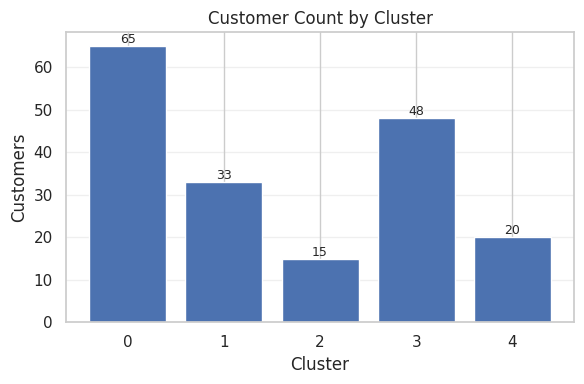

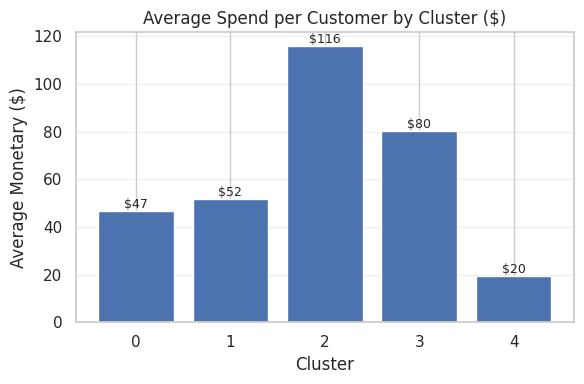

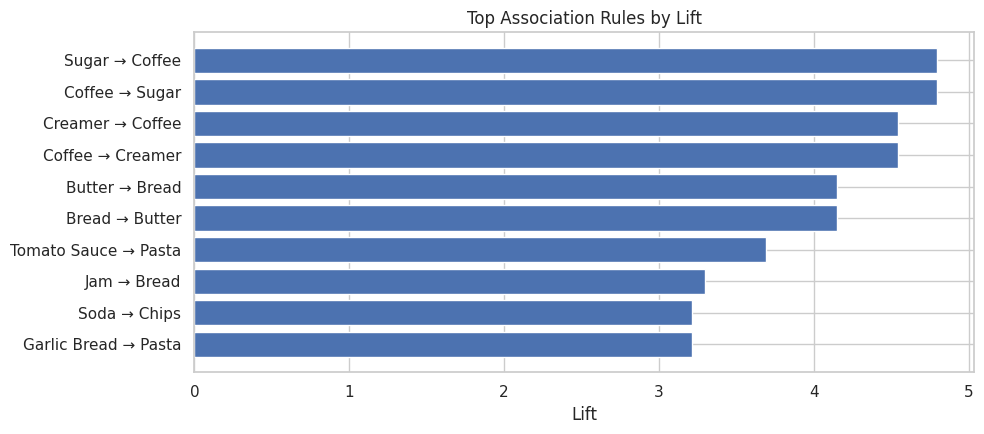

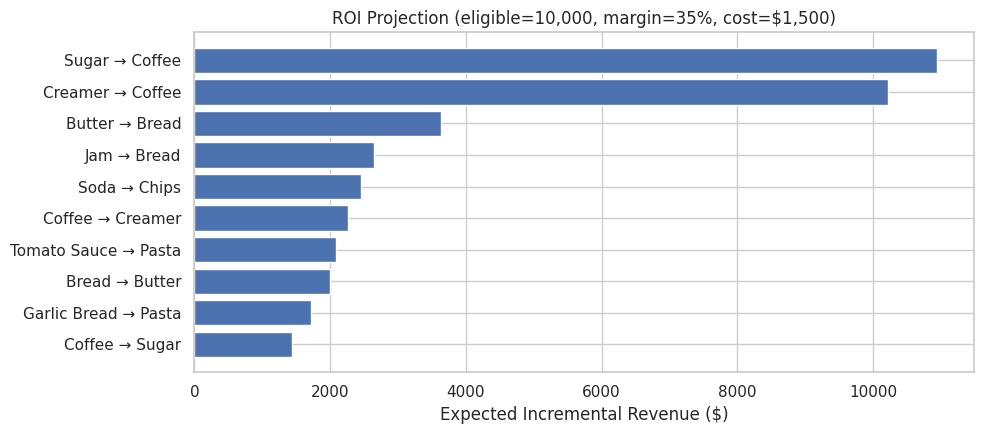

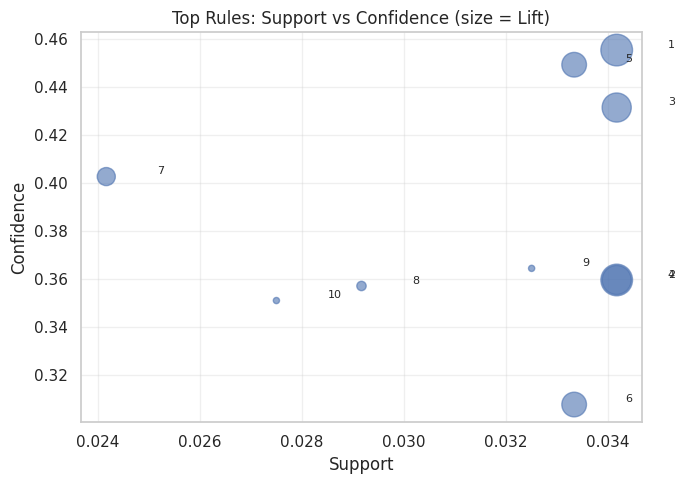

In [80]:
# ===================== Business Intelligence Summary + ROI =====================
# This cell:
# 1) Prints a concise executive summary from your current objects.
# 2) Builds an ROI table using top association rules (support/confidence/lift).
# 3) Produces charts for the report: cluster sizes, avg spend by cluster,
#    top rules by lift, and expected incremental revenue per rule.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------- 0) Sanity checks / fallbacks -------------------------
assert 'rfm_clean' in globals(), "rfm_clean not found. Run your RFM + cleaning cell first."
assert 'clusters'   in globals(), "clusters labels not found. Run K-Means cell first."
assert 'df'         in globals(), "df not found. Load your transactions first."
assert 'PRODUCT_COL' in globals(), "PRODUCT_COL not set. Run the basket builder cell first."

# rules to use for BI; prefer filtered rules_view, otherwise fall back to all rules
if 'rules_view' in globals() and not (rules_view is None or rules_view.empty):
    RULES_FOR_BI = rules_view.copy()
elif 'rules_all' in globals() and not rules_all.empty:
    RULES_FOR_BI = rules_all.copy()
else:
    raise ValueError("No rules available. Run Apriori to create rules_all or rules_view.")

# If cluster_profiles is not in memory, build a simple one
if 'cluster_profiles' not in globals():
    clustering_features_soft = [c for c in rfm_clean.columns if c not in ["CustomerID","Cluster"]]
    cluster_profiles = rfm_clean.groupby("Cluster")[clustering_features_soft].mean().round(2)

# ----------------------- 1) Executive summary figures -------------------------
# Cluster sizes and mean AOV
sizes = rfm_clean["Cluster"].value_counts().sort_index()
aov_by_cluster = rfm_clean.groupby("Cluster")["AvgOrderValue"].mean()

# Optional: pull best method from your evaluator if available
chosen_method = "K-Means (k=5)"
if 'results' in globals():
    # results from your evaluate_segmentations(); highest FinalScore on top
    chosen_method = f"{results.iloc[0]['Method']} (k=5)"

print("=== Executive Summary (auto-filled numbers) ===")
print(f"Chosen segmentation method: {chosen_method}")
print("\nCluster sizes:")
for cid, cnt in sizes.items():
    print(f"  Cluster {cid}: {cnt} customers")

print("\nAverage Order Value by cluster ($):")
for cid, val in aov_by_cluster.round(2).items():
    print(f"  Cluster {cid}: {val:.2f}")

# ----------------------- 2) Top rules to cite in report -----------------------
def short_rule_strings(rules_df, n=5):
    r = rules_df.sort_values(["lift","confidence"], ascending=False).head(n)
    out = []
    for _, row in r.iterrows():
        a = ", ".join(map(str, row["antecedents"]))
        c = ", ".join(map(str, row["consequents"]))
        out.append(f"{a} ⇒ {c}  (support={row['support']:.2%}, conf={row['confidence']:.2%}, lift={row['lift']:.2f})")
    return out

print("\nTop rules to cite (by lift):")
for s in short_rule_strings(RULES_FOR_BI, n=5):
    print(" -", s)

# ----------------------- 3) ROI projections from rules ------------------------
# Assumptions (edit to fit your scenario)
MARGIN = 0.35            # gross margin on consequents (e.g., 35%)
ELIGIBLE_BASKETS = 10000 # number of times the recommendation will be shown
COST = 1500              # total cost of building/running the test

# Estimate base attach rate of each consequent as its overall prevalence
# (share of baskets containing the item)
assert 'basket_bool' in globals(), "basket_bool not found. Run the basket builder cell."
prod_prevalence = basket_bool.mean(axis=0).to_dict()

def build_roi_table(rules_df, df_transactions, product_col, top_n=10,
                    eligible=ELIGIBLE_BASKETS, margin=MARGIN, cost=COST):
    rows = []
    r = rules_df.sort_values(["lift","confidence"], ascending=False).head(top_n).copy()
    for _, row in r.iterrows():
        ants = list(row["antecedents"])
        cons = list(row["consequents"])
        # base attach = avg prevalence of the consequent items
        base_attach = float(np.mean([prod_prevalence.get(c, 0.0) for c in cons]))

        # approximate average unit price for consequents
        cons_prices = df_transactions[df_transactions[product_col].isin(cons)]["UnitPrice"]
        avg_price = float(cons_prices.mean()) if not cons_prices.empty else float(rfm_clean["AvgOrderValue"].mean())

        lift = float(row["lift"])
        inc_attach = max(lift - 1, 0) * base_attach                  # incremental attach rate
        incr_rev  = eligible * inc_attach * avg_price * margin       # incremental revenue
        roi       = (incr_rev - cost) / cost if cost else np.nan

        rows.append({
            "antecedents": ", ".join(ants),
            "consequents": ", ".join(cons),
            "support": float(row["support"]),
            "confidence": float(row["confidence"]),
            "lift": lift,
            "base_attach_%": base_attach * 100,
            "incremental_attach_%": inc_attach * 100,
            "avg_consequent_price": avg_price,
            "eligible_baskets": int(eligible),
            "gross_margin": float(margin),
            "campaign_cost": float(cost),
            "expected_incremental_revenue": incr_rev,
            "ROI": roi
        })
    return pd.DataFrame(rows)

roi_table = build_roi_table(
    RULES_FOR_BI, df_transactions=df, product_col=PRODUCT_COL, top_n=10,
    eligible=ELIGIBLE_BASKETS, margin=MARGIN, cost=COST
)

# Clean display
disp_cols = [
    "antecedents","consequents","support","confidence","lift",
    "base_attach_%","incremental_attach_%","avg_consequent_price",
    "eligible_baskets","gross_margin","campaign_cost",
    "expected_incremental_revenue","ROI"
]
print("\nQuick ROI table (top rules):")
print(roi_table[disp_cols].round({
    "support":3, "confidence":3, "lift":2, "base_attach_%":2, "incremental_attach_%":2,
    "avg_consequent_price":2, "expected_incremental_revenue":2, "ROI":2
}).to_string(index=False))

# Save for the report if you want
roi_table.to_csv("roi_rules_table.csv", index=False)
print("\nSaved: roi_rules_table.csv")

# ----------------------- 4) Charts for the report ----------------------------
# 4a. Cluster sizes
plt.figure(figsize=(6,4))
bars = plt.bar(sizes.index.astype(str), sizes.values)
plt.title("Customer Count by Cluster")
plt.xlabel("Cluster"); plt.ylabel("Customers"); plt.grid(axis="y", alpha=0.3)
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
             ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

# 4b. Average spend per customer by cluster
means_monetary = rfm_clean.groupby("Cluster")["Monetary"].mean()
plt.figure(figsize=(6,4))
bars = plt.bar(means_monetary.index.astype(str), means_monetary.values)
plt.title("Average Spend per Customer by Cluster ($)")
plt.xlabel("Cluster"); plt.ylabel("Average Monetary ($)"); plt.grid(axis="y", alpha=0.3)
for b, val in zip(bars, means_monetary.values):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"${val:.0f}",
             ha="center", va="bottom", fontsize=9)
plt.tight_layout(); plt.show()

# 4c. Top rules by lift (bar)
top_rules = RULES_FOR_BI.sort_values(["lift","confidence"], ascending=False).head(10).copy()
labels = [", ".join(map(str, a)) + " → " + ", ".join(map(str, c))
          for a, c in zip(top_rules["antecedents"], top_rules["consequents"])]
plt.figure(figsize=(10, max(4, 0.45*len(top_rules))))
plt.barh(range(len(top_rules)), top_rules["lift"].values)
plt.yticks(range(len(top_rules)), labels)
plt.gca().invert_yaxis()
plt.xlabel("Lift"); plt.title("Top Association Rules by Lift")
plt.tight_layout(); plt.show()

# 4d. Expected incremental revenue (bar)
roi_sorted = roi_table.sort_values("expected_incremental_revenue", ascending=False).head(10)
labels_roi = [f"{a} → {c}" for a, c in zip(roi_sorted["antecedents"], roi_sorted["consequents"])]
plt.figure(figsize=(10, max(4, 0.45*len(roi_sorted))))
plt.barh(range(len(roi_sorted)), roi_sorted["expected_incremental_revenue"].values)
plt.yticks(range(len(roi_sorted)), labels_roi)
plt.gca().invert_yaxis()
plt.xlabel("Expected Incremental Revenue ($)")
plt.title(f"ROI Projection (eligible={ELIGIBLE_BASKETS:,}, margin={MARGIN:.0%}, cost=${COST:,})")
plt.tight_layout(); plt.show()

# 4e. Support vs Confidence (bubble size = lift) for the same rules
r = top_rules.copy()
sizes = 500 * (r["lift"] - r["lift"].min()) / (r["lift"].max() - r["lift"].min() + 1e-12) + 20
plt.figure(figsize=(7,5))
plt.scatter(r["support"], r["confidence"], s=sizes, alpha=0.6)
for i, lbl in enumerate(labels):
    plt.text(r["support"].iloc[i] + 0.001, r["confidence"].iloc[i] + 0.001, str(i+1), fontsize=8)
plt.xlabel("Support"); plt.ylabel("Confidence")
plt.title("Top Rules: Support vs Confidence (size = Lift)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
# ==============================================================================
